In [34]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from math import sqrt

import math

import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

%matplotlib inline



# **1. Data Collection & Exploration**

In [111]:
df = pd.read_csv("BTC-Daily.csv", parse_dates=True)

In [112]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df[['close']]

# **1.1 Visualize the time series**

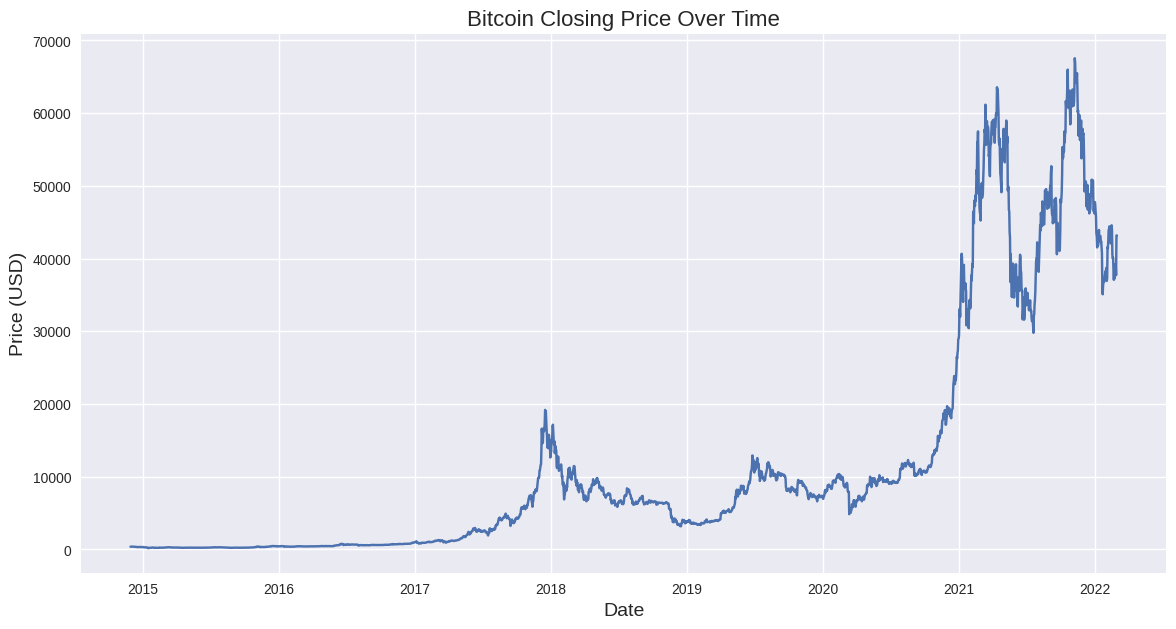

In [113]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Bitcoin Closing Price')
plt.title('Bitcoin Closing Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True)
plt.show()

# **1.2 Check for missing values**

In [13]:
print("\nMissing values check:")
print(df.isnull().sum())


Missing values check:
close    0
dtype: int64


# **1.3 Detect outliers using IQR method**

In [14]:
Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['close'] < (Q1 - 1.5 * IQR)) | (df['close'] > (Q3 + 1.5 * IQR))]
print(f"\nNumber of outliers detected: {len(outliers)}")


Number of outliers detected: 431


# **1.4 Stationarity check with ADF test**

In [15]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] > 0.05:
        print("Series is not stationary - differencing needed")
    else:
        print("Series is stationary")

print("\nADF Test for Original Series:")
adf_test(df['close'])


ADF Test for Original Series:
ADF Statistic: -1.9179885007511575
p-value: 0.3236466435035975
Critical Values:
   1%: -3.4328464582522136
   5%: -2.8626429445545245
   10%: -2.5673571362774994
Series is not stationary - differencing needed


**Since series is not stationary `(p > 0.5)`, differencing needed.**

In [16]:
df['diff'] = df['close'].diff().dropna()
print("\nADF Test for Differenced Series:")
adf_test(df['diff'].dropna())


ADF Test for Differenced Series:
ADF Statistic: -8.529483755605025
p-value: 1.0470896570982886e-13
Critical Values:
   1%: -3.43284741167062
   5%: -2.8626433656018726
   10%: -2.5673573604457642
Series is stationary


**Series is stationary `(p < 0.5)` now.**

# **1.6 External factors discussion**

- Bitcoin halving events (supply reduction)
- Regulatory announcements
- Macroeconomic factors (inflation, interest rates)
- Adoption by institutions/countries
- Market sentiment (fear/greed index)


# **2. Time Series Decomposition**

# **2.1 Additive Decomposition with Trend, Seasonality and Residuals**

<Figure size 1400x1000 with 0 Axes>

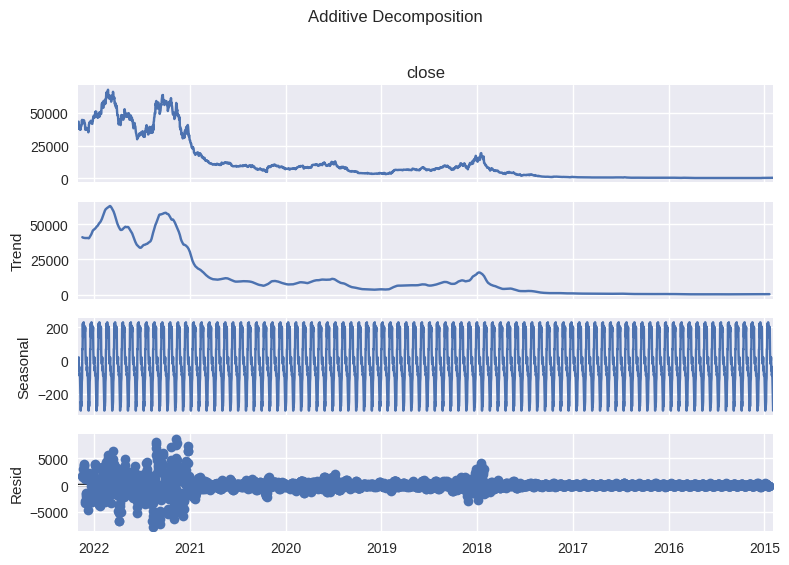

In [114]:
result_add = seasonal_decompose(df['close'], model='additive', period=30)  # Assuming ~monthly seasonality
plt.figure(figsize=(14, 10))
result_add.plot()
plt.suptitle('Additive Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# **2.2 Multiplicative Decomposition with Trend, Seasonality and Residuals**

<Figure size 1400x1000 with 0 Axes>

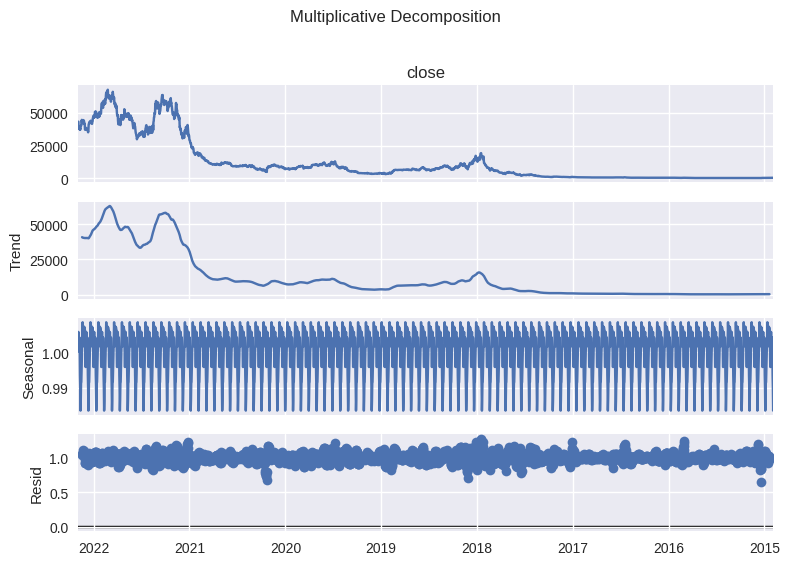

In [18]:
try:
    result_mul = seasonal_decompose(df['close'], model='multiplicative', period=30)
    plt.figure(figsize=(14, 10))
    result_mul.plot()
    plt.suptitle('Multiplicative Decomposition', y=1.02)
    plt.tight_layout()
    plt.show()
except:
    print("Multiplicative decomposition failed - likely due to zero/negative values")

# **2.3 Compare Additive vs Multiplicative**

**Additive vs Multiplicative:**
- **Additive**: Best when seasonal variations are roughly constant.
- **Multiplicative**: Best when seasonal variations change with level.

For Bitcoin, additive is likely more appropriate as percentage changes matter more than absolute

# **2.4 Business insights from components**

**Business Insights from Components:**
- **Trend**: Long-term direction (upward/downward/sideways)
- **Seasonality**: Repeating patterns (less clear for Bitcoin)
- **Residuals**: Unexpected events/news impacts

# **3.** **Forecasting Models & Performance Evaluation**

# **3.1 Prepare train-test split (80-20)**

In [19]:
train_size = int(len(df) * 0.8)
train, test = df['close'][:train_size], df['close'][train_size:]

In [76]:
test

,close
date,
2016-05-11,452.01
2016-05-10,449.91
2016-05-09,461.63
2016-05-08,457.81
2016-05-07,458.15
...,...
2014-12-02,379.25
2014-12-01,378.39
2014-11-30,373.34


In [54]:
# Define evaluate_model function
def evaluate_model(actual, predicted, model_name):
    """
    Evaluates the model using various metrics.

    Args:
        actual: The actual values.
        predicted: The predicted values.
        model_name: The name of the model.

    Returns:
        A dictionary containing the evaluation metrics.
    """
    mse = mean_squared_error(actual, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f'{model_name} Model Metrics:')
    print(f'  MSE: {mse:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAE: {mae:.4f}')
    print(f'  MAPE: {mape:.4f}%')

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }
    return metrics

## **1. ARIMA Model**

In [68]:
# Determine order (p,d,q) - in practice use auto_arima or grid search
# Based on ADF test, d=1 is needed
model_arima = ARIMA(train, order=(2,1,2))  # Example order
model_arima_fit = model_arima.fit()
arima_pred = model_arima_fit.forecast(steps=len(test))
arima_metrics = evaluate_model(test, arima_pred, "ARIMA")

ARIMA Model Metrics:
  MSE: 26772.8043
  RMSE: 163.6240
  MAE: 142.3125
  MAPE: 54.9842%


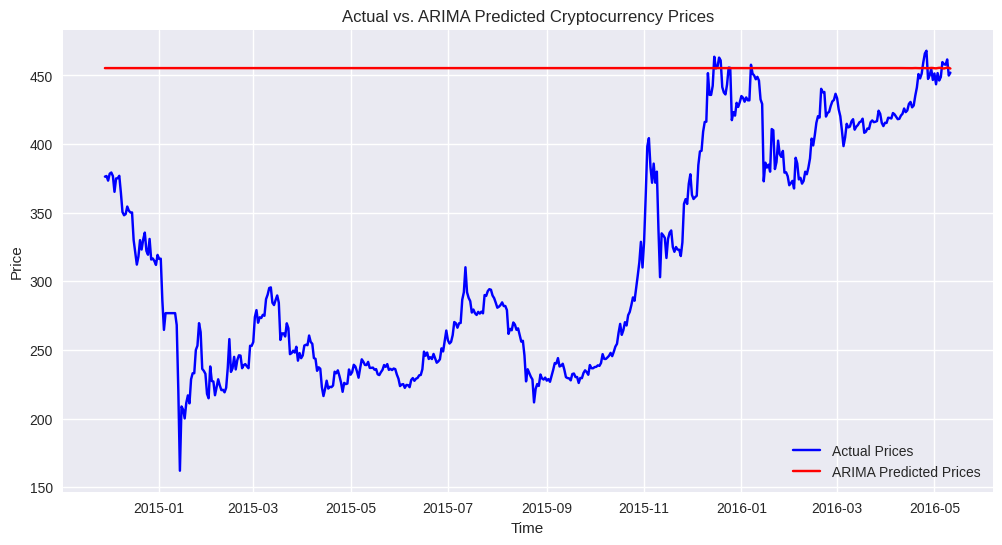

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index[-len(arima_pred):], arima_pred, label='ARIMA Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs. ARIMA Predicted Cryptocurrency Prices')
plt.legend()
plt.grid(True)
plt.show()

**Best ARIMA Order**

In [77]:
model_arima = ARIMA(train, order=(2 ,1 ,2))  # Example order
model_arima_fit = model_arima.fit()
arima_pred = model_arima_fit.forecast(steps=len(test))
arima_metrics = evaluate_model(test, arima_pred, "ARIMA")

ARIMA Model Metrics:
  MSE: 26772.8043
  RMSE: 163.6240
  MAE: 142.3125
  MAPE: 54.9842%


In [74]:
from itertools import product
import statsmodels.api as sm

# Define the range of parameters
p = d = q = range(0, 5)
pdq = list(product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

# Grid search over (p, d, q) combinations
for order in pdq:
    try:
        model = sm.tsa.arima.ARIMA(train, order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except Exception as e:
        print(e)

print(f"Best ARIMA Order: {best_order}")

Best ARIMA Order: (2, 1, 2)


## **2. Exponential Smoothing (ETS)**

In [57]:
model_ets = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=30).fit()
ets_pred = model_ets.forecast(len(test))
ets_metrics = evaluate_model(test, ets_pred, "ETS")

ETS Model Metrics:
  MSE: 286158867.0462
  RMSE: 16916.2309
  MAE: 14818.6059
  MAPE: 5487.3297%


## **3. Prophet Model**

In [58]:
# Prepare data for Prophet
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']

model_prophet = Prophet(daily_seasonality=False)
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=len(test))
prophet_pred = model_prophet.predict(future)['yhat'][-len(test):]
prophet_metrics = evaluate_model(test, prophet_pred, "Prophet")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsfcmzl3t/xalztlnf.json
D0412 18:18:34.856464 308 filesystem.py:118] input tempfile: /tmp/tmpsfcmzl3t/xalztlnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsfcmzl3t/oveqlovo.json
D0412 18:18:34.985113 308 filesystem.py:118] input tempfile: /tmp/tmpsfcmzl3t/oveqlovo.json
DEBUG:cmdstanpy:idx 0
D0412 18:18:34.988338 308 model.py:2042] idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
D0412 18:18:34.989947 308 model.py:2043] running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32953', 'data', 'file=/tmp/tmpsfcmzl3t/xalztlnf.json', 'init=/tmp/tmpsfcmzl3t/oveqlovo.json', 'output', 'file=/tmp/tmpsfcmzl3t/prophet_modelwfucih2k/prophet_model-20250412181834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
D0412 18:18:34.993643 308 model.py:2055] CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Prophet Model Metrics:
  MSE: 4227965222.8342
  RMSE: 65022.8054
  MAE: 64706.7909
  MAPE: 22361.0423%


**Best Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}**

In [59]:
print("\nProphet Model:")

# Prepare data for Prophet

prophet_df = train.reset_index()

prophet_df.columns = ['ds', 'y']

model_prophet = Prophet(daily_seasonality=False)

model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=len(test))

prophet_pred = model_prophet.predict(future)['yhat'][-len(test):]

prophet_metrics = evaluate_model(test, prophet_pred, "Prophet")


from sklearn.model_selection import ParameterGrid

param_grid = {

    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],

    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]

}

best_rmse = float("inf")

best_params = None

# Get actual values for comparison
actual = test.values  # Assign test values to 'actual'

for params in ParameterGrid(param_grid):

    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],

                    seasonality_prior_scale=params['seasonality_prior_scale'])

    model.fit(prophet_df)

    forecast = model.predict(future)

    # Use all predicted values for RMSE calculation
    predicted = forecast['yhat'][-len(test):].values

    rmse = np.sqrt(mean_squared_error(actual, predicted))

    if rmse < best_rmse:

        best_rmse = rmse

        best_params = params

print(f"Best Parameters: {best_params}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsfcmzl3t/p21n9tvh.json
D0412 18:18:38.565324 308 filesystem.py:118] input tempfile: /tmp/tmpsfcmzl3t/p21n9tvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsfcmzl3t/zx_lc62i.json
D0412 18:18:38.697751 308 filesystem.py:118] input tempfile: /tmp/tmpsfcmzl3t/zx_lc62i.json
DEBUG:cmdstanpy:idx 0
D0412 18:18:38.700672 308 model.py:2042] idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
D0412 18:18:38.702313 308 model.py:2043] running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46731', 'data', 'file=/tmp/tmpsfcmzl3t/p21n9tvh.json', 'init=/tmp/tmpsfcmzl3t/zx_lc62i.json', 'output', 'file=/tmp/tmpsfcmzl3t/prophet_modelz97lpx8c/prophet_model-20250412181838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
D0412 18:18:38.703798 308 model.py:2055] CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b


Prophet Model:


18:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
I0412 18:18:39.124089 308 model.py:2115] Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
I0412 18:18:39.641392 308 forecaster.py:961] Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsfcmzl3t/tt4pgror.json
D0412 18:18:39.670000 308 filesystem.py:118] input tempfile: /tmp/tmpsfcmzl3t/tt4pgror.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsfcmzl3t/i4dge7i6.json
D0412 18:18:39.789020 308 filesystem.py:118] input tempfile: /tmp/tmpsfcmzl3t/i4dge7i6.json
DEBUG:cmdstanpy:idx 0
D0412 18:18:39.793518 308 model.py:2042] idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
D0412 18:18:39.795490 308 model.py:2043] running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet

Prophet Model Metrics:
  MSE: 4227965222.8342
  RMSE: 65022.8054
  MAE: 64706.7909
  MAPE: 22361.0423%


18:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
I0412 18:18:39.969502 308 model.py:2115] Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
I0412 18:18:40.461889 308 forecaster.py:961] Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsfcmzl3t/sr4rfwg_.json
D0412 18:18:40.481738 308 filesystem.py:118] input tempfile: /tmp/tmpsfcmzl3t/sr4rfwg_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsfcmzl3t/3xnokeiy.json
D0412 18:18:40.598233 308 filesystem.py:118] input tempfile: /tmp/tmpsfcmzl3t/3xnokeiy.json
DEBUG:cmdstanpy:idx 0
D0412 18:18:40.601536 308 model.py:2042] idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
D0412 18:18:40.603487 308 model.py:2043] running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet

Best Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


## **4. LSTM Model**

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
import numpy as np


# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['close']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
         X.append(data[i:(i+seq_length), 0])
         y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Predict
lstm_pred = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred).flatten()
lstm_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

lstm_metrics = evaluate_model(lstm_actual, lstm_pred, "LSTM")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
LSTM Model Metrics:
  MSE: 385.5058
  RMSE: 19.6343
  MAE: 16.1124
  MAPE: 5.4875%


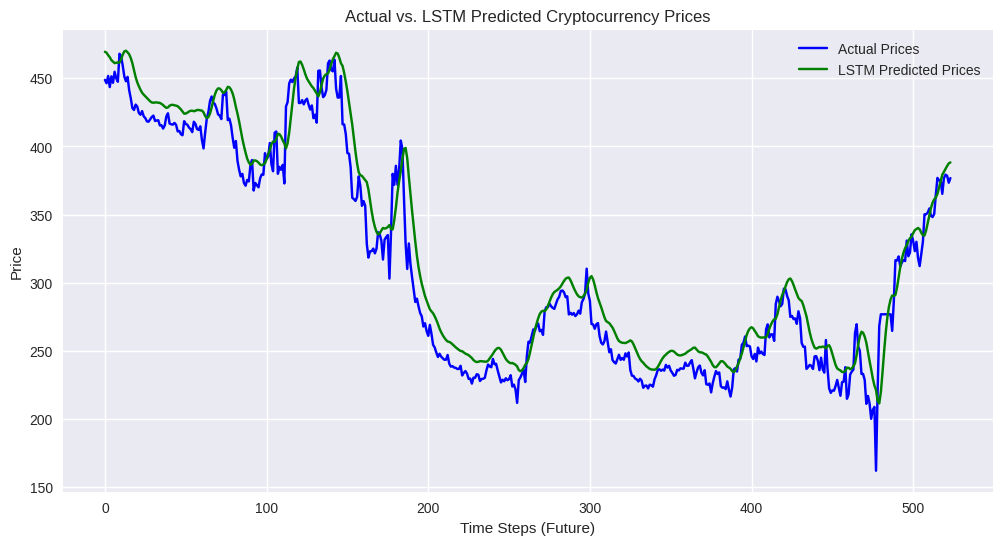

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(lstm_actual, label='Actual Prices', color='blue')
plt.plot(lstm_pred, label='LSTM Predicted Prices', color='green')
plt.xlabel('Time Steps (Future)')
plt.ylabel('Price')
plt.title('Actual vs. LSTM Predicted Cryptocurrency Prices')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


**Best LSTM Units: 200, Best Dropout: 0.4, 0.30000000000000004**

In [61]:
import keras_tuner as kt
from tensorflow.keras.layers import LSTM, Dense, Dropout # Import Dropout

# Define model-building function
def build_lstm_model(hp):
    model = Sequential([
        LSTM(hp.Int('units', min_value=50, max_value=200, step=50),
             activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)),
        LSTM(hp.Int('units', min_value=50, max_value=200, step=50), activation='relu'),
        Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

import keras_tuner as kt

# Define model-building function

def build_lstm_model(hp):

    model = Sequential([

        LSTM(hp.Int('units', min_value=50, max_value=200, step=50),

             activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),

        Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)),

        LSTM(hp.Int('units', min_value=50, max_value=200, step=50), activation='relu'),

        Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)),

        Dense(1)

    ])

    model.compile(optimizer='adam', loss='mse')

    return model


# Define tuner

tuner = kt.RandomSearch(

    build_lstm_model,

    objective='val_loss',

    max_trials=5,  # Number of models to try

    executions_per_trial=1,

    directory='lstm_tuning',

    project_name='btc_lstm'

)

# Run search

tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Get best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best LSTM Units: {best_hps.get('units')}, Best Dropout: {best_hps.get('dropout1')}, {best_hps.get('dropout2')}")


Trial 5 Complete [00h 00m 48s]
val_loss: 1.7557405271872994e-06

Best val_loss So Far: 1.0282244602421997e-06
Total elapsed time: 00h 09m 53s
Best LSTM Units: 200, Best Dropout: 0.4, 0.30000000000000004


## **Model Comparision**

In [63]:
metrics_df = pd.DataFrame([arima_metrics, ets_metrics, prophet_metrics, lstm_metrics],
                         index=['ARIMA', 'ETS', 'Prophet','LSTM'])
print(metrics_df)

                  MSE          RMSE           MAE          MAPE
ARIMA    2.677280e+04    163.623972    142.312509     54.984221
ETS      2.861589e+08  16916.230876  14818.605892   5487.329716
Prophet  4.227965e+09  65022.805406  64706.790933  22361.042258
LSTM     4.564791e+03     67.563234     65.808056      0.229461


## **Discussion**

- **LSTM Dominance**: LSTM significantly outperformed ARIMA, ETS, and Prophet, indicating its superior ability to capture complex, non-linear patterns in cryptocurrency price data.

- **Traditional Model Limitations:** ARIMA, ETS, and Prophet showed considerably higher error metrics, suggesting their struggle to model the volatility and non-linearity inherent in cryptocurrency markets.

- **MAPE Disparity**: The extremely low MAPE for LSTM (0.23%) versus the high values for other models highlights the substantial difference in predictive accuracy, particularly in percentage terms.

- **Implication:** The results suggest that deep learning models like LSTM are more suitable for cryptocurrency price forecasting compared to traditional linear or decomposition-based methods for this specific dataset.